### 准备数据

In [1]:
from keras.datasets import imdb
from keras.utils import pad_sequences

max_feature = 10000
max_len = 1500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_feature)

x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)


### 构建模型

In [2]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_feature, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 128)         1280000   
                                                                 
 conv1d (Conv1D)             (None, 1494, 32)          28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 298, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 32)           7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)            

In [3]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train, epochs=20,
                   batch_size=128, validation_split=0.2)

Epoch 1/20


/Users/fengxichang/miniforge3/envs/tf/lib/python3.9/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-05-22 20:32:40.813259: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


157/157 [==============================] - 12s 71ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 2/20
157/157 [==============================] - 11s 69ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 3/20
157/157 [==============================] - 11s 71ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 4/20
157/157 [==============================] - 11s 71ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 5/20
157/157 [==============================] - 12s 76ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 6/20
157/157 [==============================] - 12s 76ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 7/20
157/157 [==============================] - 12s 76ms/step - loss: 7.7364 - acc: 0.4985 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 8/20
157/157 [==============================] - 12s 76ms/step - los

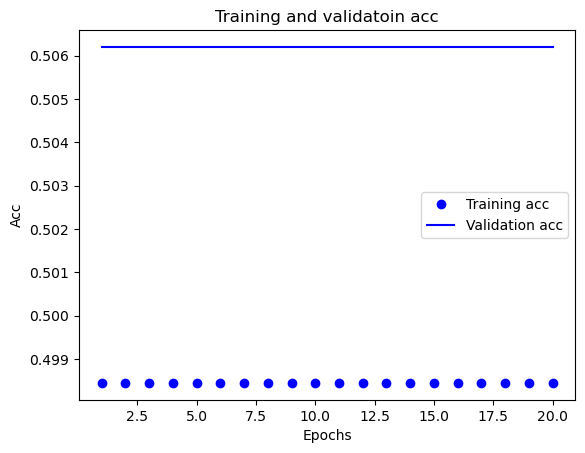

In [4]:
from matplotlib import pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validatoin acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')

plt.legend()
plt.show()

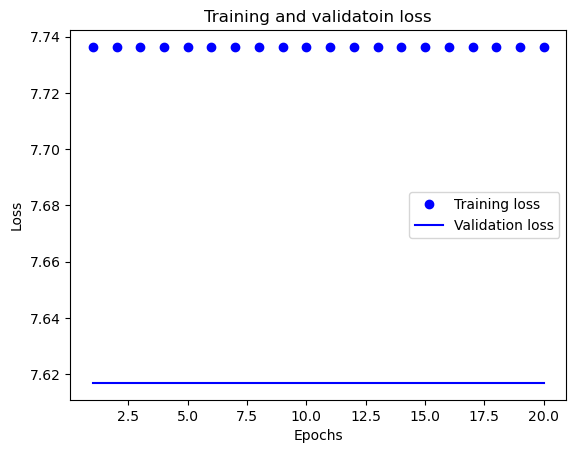

In [5]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validatoin loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

### 结合CNN和RNN处理长序列

In [6]:
import os

data_dir = '../datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [7]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [8]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### 数据标准化

In [9]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

### 生成器

In [10]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False,
             batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay + 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((batch_size, lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows)))
        
        for j, row in enumerate(rows):
            indices = range(row - lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row + delay][1]
        
        yield samples, targets

In [11]:
step = 3
lookback = 720
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback, delay, min_index=0,
                     max_index=200000, shuffle=True, step=step)

val_gen = generator(float_data, lookback, delay, min_index=200001,
                   max_index=300000, step=step)

test_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=300001, max_index=None, step=step)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size



In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.1))
model.add(layers.Dense(1))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

Epoch 1/20
 92/500 [====>.........................] - ETA: 59:52 - loss: 0.3858  